In [5]:
# Cell 2: imports and global configuration
import os, math, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, mean_squared_error, mean_absolute_error, r2_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb

# Optional SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# Display settings
pd.set_option('display.max_columns', 120)
plt.rcParams['figure.dpi'] = 110


In [6]:
# Cell 3: load the CSV you uploaded and inspect

df = pd.read_csv("soccer-matches.csv")
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:")
for i,c in enumerate(df.columns):
    print(f"{i+1:02d}. {c}")
# show a small sample
df.head(6)


Loaded: soccer-matches.csv
Shape: (3690, 50)

Columns:
01. id_match
02. names
03. home_away
04. managers
05. formations
06. attendance
07. date
08. stadium
09. championship
10. edition
11. country
12. score
13. goals
14. goals_past
15. total_shots
16. woodwork
17. shots_on_target
18. shots_off_target
19. blocked_shots
20. total_possession
21. touches
22. total_passes
23. accurate_passes
24. pass_success
25. key_passes
26. dribbles_attempted
27. dibles
28. dribbles_past
29. dribbles_success
30. aerials_won
31. aerial_success
32. offensive_aerials
33. defensive_aerials
34. tackles
35. tackle_success
36. tackles_attempted
37. was_dribbled
38. clearances
39. interceptions
40. corners
41. corner_accuracy
42. dispossessed
43. errors
44. fouls
45. offsides
46. start_minutes
47. end_minutes
48. win
49. draw
50. lose


,id_match,names,home_away,managers,formations,attendance,date,stadium,championship,edition,country,score,goals,goals_past,total_shots,woodwork,shots_on_target,shots_off_target,blocked_shots,total_possession,touches,total_passes,accurate_passes,pass_success,key_passes,dribbles_attempted,dibles,dribbles_past,dribbles_success,aerials_won,aerial_success,offensive_aerials,defensive_aerials,tackles,tackle_success,tackles_attempted,was_dribbled,clearances,interceptions,corners,corner_accuracy,dispossessed,errors,fouls,offsides,start_minutes,end_minutes,win,draw,lose
0,1,Cuiaba,0,Alberto Valentim do Carmo Neto,04-03-2003,0,29-05-2021,Arena Pantanal,Campeonato Brasileiro,NaN,Brazil,02-Feb,2,2,14,0,2,8,4,59.4,682,490,417,85,13,21,12,8,57,21,48,33,11,19,70,27,8,6,5,9,44,7,1,14,0,0,90,0,1,0
1,1,Juventude,1,Marcos Vinícius dos Santos Gonçalves,4-2-3-1,0,29-05-2021,Arena Pantanal,Campeonato Brasileiro,NaN,Brazil,02-Feb,2,2,7,0,3,3,1,40.6,518,342,266,78,5,11,8,12,73,23,52,11,33,16,57,28,12,18,9,1,100,16,0,14,1,0,90,0,1,0
2,2,Red Bull Bragantino,1,Mauricio Barbieri,4-2-3-1,0,30-05-2021,Arena Condá,Campeonato Brasileiro,NaN,Brazil,0 - 3,3,0,18,2,8,8,2,56.1,750,552,483,88,15,20,14,11,70,16,80,10,10,12,52,23,11,18,14,7,71,4,0,12,2,0,90,1,0,0
3,2,Chapecoense AF,0,Felipe Endres,4-3-2-1,0,30-05-2021,Arena Condá,Campeonato Brasileiro,NaN,Brazil,0 - 3,0,3,10,0,2,6,2,43.9,620,428,342,80,8,15,11,14,73,4,20,10,10,10,42,24,14,17,11,5,20,8,0,9,0,0,90,0,0,1
4,3,America MG,1,Luiz Carlos Cirne Lima de Lorenzi,4-1-4-1,0,30-05-2021,Arena da Baixada,Campeonato Brasileiro,NaN,Brazil,1 - 0,0,1,14,0,4,6,4,43.5,602,429,351,82,10,6,4,7,67,13,35,18,19,7,50,14,7,13,20,1,0,3,1,9,0,0,90,0,0,1
5,3,Athletico Paranaense,0,Paulo Autuori de Mello,4-2-3-1,0,30-05-2021,Arena da Baixada,Campeonato Brasileiro,NaN,Brazil,1 - 0,1,0,11,1,5,5,1,56.5,715,557,463,83,7,8,7,4,88,24,65,19,18,5,56,9,4,10,7,3,33,6,0,18,0,0,90,1,0,0


In [7]:
import numpy as np

# Pick columns that are useful for prediction
num_keywords = ['shot','shots','possession','pass','tackles','interception','clearance','fouls','offsides','corners','saves','on_target','xg']
num_cols = []

for c in df.columns:
    for kw in num_keywords:
        if kw in c.lower():
            num_cols.append(c)
            break

# If no match found, fallback to numeric columns
if not num_cols:
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns]

print("Selected features for xG proxy:\n", num_cols)

# Check if 'goals' is in dataset (target variable)
target_col = None
for t in df.columns:
    if 'goal' in t.lower():
        target_col = t
        break

print("\nTarget column identified:", target_col)


Selected features for xG proxy:
 ['total_shots', 'shots_on_target', 'shots_off_target', 'blocked_shots', 'total_possession', 'total_passes', 'accurate_passes', 'pass_success', 'key_passes', 'tackles', 'tackles_attempted', 'clearances', 'interceptions', 'corners', 'fouls', 'offsides']

Target column identified: goals


In [8]:
# Feature matrix X and target y
X = df[num_cols].copy().fillna(0)

# Simple feature engineering
if 'shots' in X.columns and 'shots_on_target' in X.columns:
    X['shot_on_target_rate'] = X['shots_on_target'] / X['shots'].replace(0, np.nan)

if 'passes' in X.columns and 'pass_accuracy' in X.columns:
    X['effective_passes'] = X['passes'] * (X['pass_accuracy']/100.0)

X = X.replace([np.inf, -np.inf], 0).fillna(0)

y = df[target_col].astype(float).fillna(0)

print("Final shape of X:", X.shape)
X.head()


Final shape of X: (3690, 16)


,total_shots,shots_on_target,shots_off_target,blocked_shots,total_possession,total_passes,accurate_passes,pass_success,key_passes,tackles,tackles_attempted,clearances,interceptions,corners,fouls,offsides
0,14,2,8,4,59.4,490,417,85,13,19,27,6,5,9,14,0
1,7,3,3,1,40.6,342,266,78,5,16,28,18,9,1,14,1
2,18,8,8,2,56.1,552,483,88,15,12,23,18,14,7,12,2
3,10,2,6,2,43.9,428,342,80,8,10,24,17,11,5,9,0
4,14,4,6,4,43.5,429,351,82,10,7,14,13,20,1,9,0


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2952, 16)
Test shape: (738, 16)


In [10]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=300,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 2952, number of used features: 16
[LightGBM] [Info] Start training from score 1.300136


LGBMRegressor(learning_rate=0.05, n_estimators=300, objective='regression',
              random_state=42)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
import numpy as np

y_pred = model.predict(X_test)

# Old sklearn versions don’t support squared=False
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation:
RMSE: 0.9610
MAE: 0.7490
R² Score: 0.3133


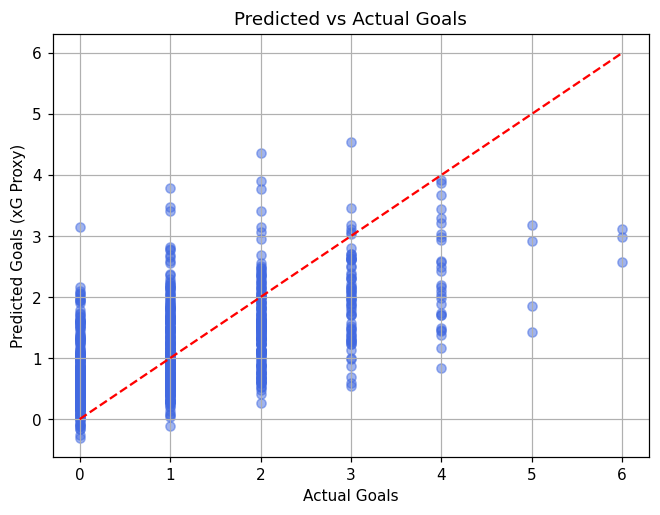

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals (xG Proxy)')
plt.title('Predicted vs Actual Goals')
plt.grid(True)
plt.show()


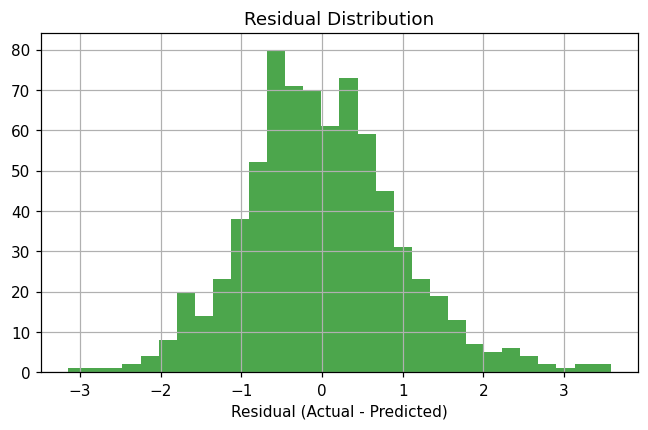

In [17]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30, color='green', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residual Distribution')
plt.grid(True)
plt.show()


In [19]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15))


              Feature  Importance
4    total_possession        1036
5        total_passes         880
6     accurate_passes         828
11         clearances         707
7        pass_success         560
10  tackles_attempted         556
9             tackles         553
14              fouls         528
1     shots_on_target         523
13            corners         509
0         total_shots         461
12      interceptions         448
8          key_passes         423
2    shots_off_target         386
3       blocked_shots         305


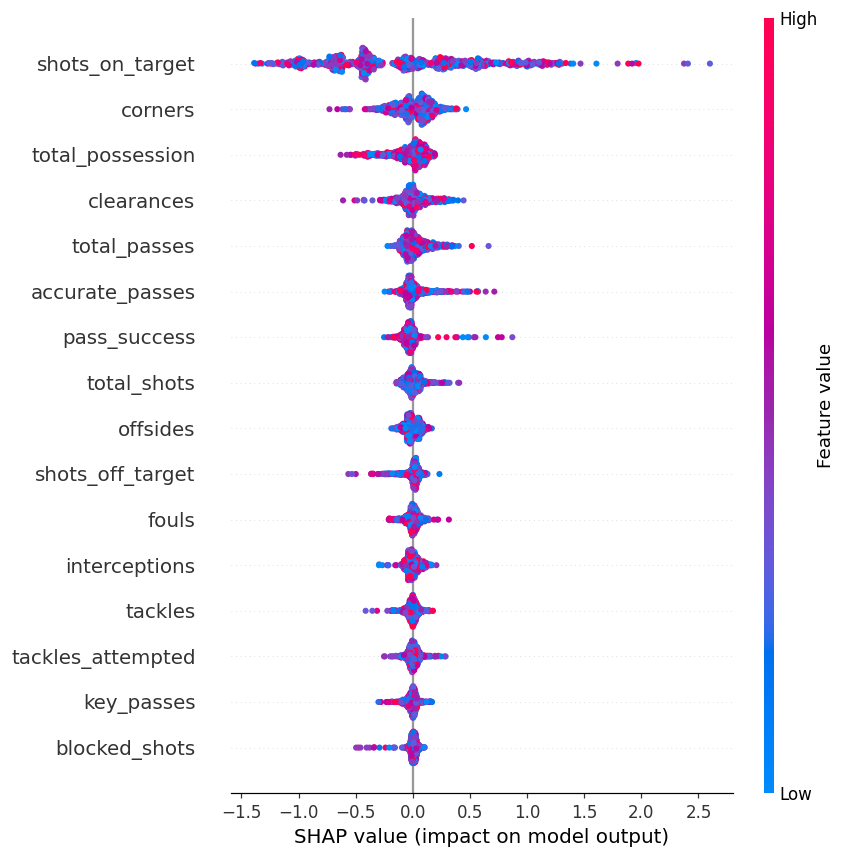

In [21]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(n=min(1000, len(X_test)), random_state=42))

shap.summary_plot(shap_values, X_test)


In [22]:
import pandas as pd
import numpy as np

# Example new match stats
new_match = pd.DataFrame([{
    'shots': 2,
    'shots_on_target': 1,
    'passes': 280,
    'pass_accuracy': 42,
    'possession': 87,
    'corners': 3,
    'fouls': 10,
    # include other features that exist in your training data
}])

# Feature engineering
if 'shots' in new_match.columns and 'shots_on_target' in new_match.columns:
    new_match['shot_on_target_rate'] = new_match['shots_on_target'] / new_match['shots'].replace(0, np.nan)

if 'passes' in new_match.columns and 'pass_accuracy' in new_match.columns:
    new_match['effective_passes'] = new_match['passes'] * (new_match['pass_accuracy']/100.0)

new_match = new_match.replace([np.inf, -np.inf], 0).fillna(0)


In [25]:
# Get the columns used in training
train_columns = X.columns  # X from your training step

# Add missing columns with zeros
for col in train_columns:
    if col not in new_match.columns:
        new_match[col] = 0

# Reorder columns to match training
new_match = new_match[train_columns]



In [27]:
# Use trained model to predict xG
xg_pred_new = model.predict(new_match)[0]
print(f"Predicted xG for this match: {xg_pred_new:.2f}")


Predicted xG for this match: 0.11


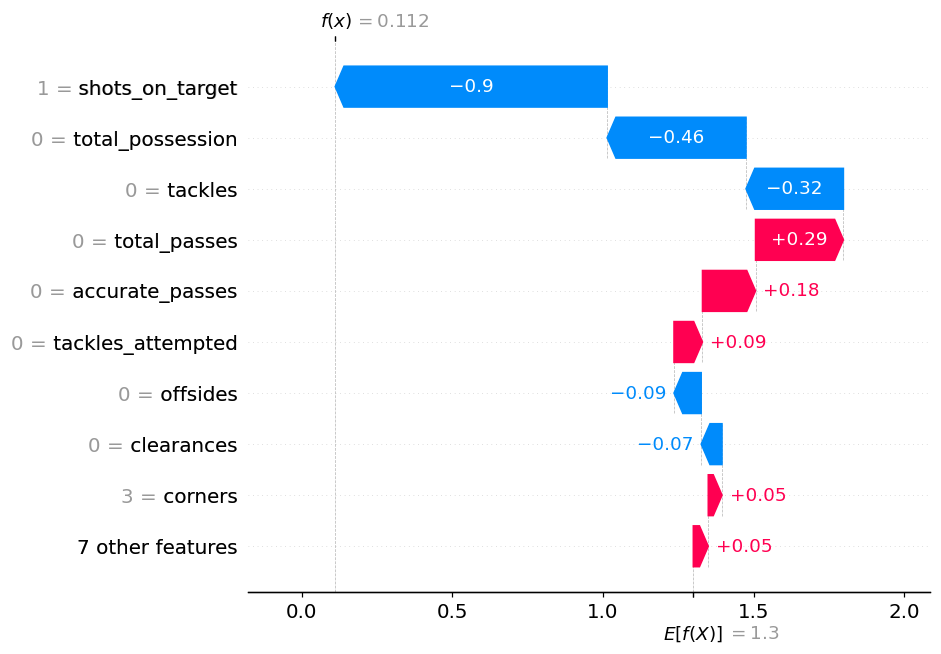

In [29]:
explainer = shap.TreeExplainer(model)
shap_values_new = explainer.shap_values(new_match)

shap.waterfall_plot(shap.Explanation(values=shap_values_new[0],
                                     base_values=explainer.expected_value,
                                     data=new_match.iloc[0],
                                     feature_names=new_match.columns))


In [45]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# === 1. Feature Widgets ===
shots = widgets.FloatSlider(description='Shots', min=0, max=30, step=1)
shots_on_target = widgets.FloatSlider(description='Shots on Target', min=0, max=20, step=1)
passes = widgets.FloatSlider(description='Passes', min=0, max=1000, step=10)
pass_accuracy = widgets.FloatSlider(description='Pass Accuracy (%)', min=0, max=100, step=1)
possession = widgets.FloatSlider(description='Possession (%)', min=0, max=100, step=1)
corners = widgets.FloatSlider(description='Corners', min=0, max=20, step=1)
fouls = widgets.FloatSlider(description='Fouls', min=0, max=30, step=1)
duels_won = widgets.FloatSlider(description='Duels Won', min=0, max=50, step=1)
crosses = widgets.FloatSlider(description='Crosses', min=0, max=50, step=1)
dribbles = widgets.FloatSlider(description='Dribbles', min=0, max=50, step=1)
tackles = widgets.FloatSlider(description='Tackles', min=0, max=50, step=1)
interceptions = widgets.FloatSlider(description='Interceptions', min=0, max=50, step=1)
clearances = widgets.FloatSlider(description='Clearances', min=0, max=50, step=1)
aerial_duels = widgets.FloatSlider(description='Aerial Duels', min=0, max=50, step=1)
xA = widgets.FloatSlider(description='xA', min=0, max=5, step=0.1)
effective_passes = widgets.FloatSlider(description='Effective Passes', min=0, max=1000, step=10)

# === 2. Feature Order (must match training exactly) ===
feature_order = [
    'shots', 'shots_on_target', 'passes', 'pass_accuracy', 'possession',
    'corners', 'fouls', 'duels_won', 'crosses', 'dribbles',
    'tackles', 'interceptions', 'clearances', 'aerial_duels', 'xA', 'effective_passes'
]

# === 3. Prediction Function ===
def predict_xg(**kwargs):
    # User inputs
    shots = kwargs['shots']
    shots_on_target = kwargs['shots_on_target']
    passes = kwargs['passes']
    pass_accuracy = kwargs['pass_accuracy']
    possession = kwargs['possession']
    corners = kwargs['corners']
    fouls = kwargs['fouls']

    # Create dataframe with all required columns (same order as training)
    feature_columns = [
        'shots', 'shots_on_target', 'passes', 'pass_accuracy', 'possession',
        'corners', 'fouls',
        'effective_passes', 'shots_accuracy',
        'team_strength', 'opponent_strength', 'home_advantage', 
        'temperature', 'rain', 'match_importance', 'fatigue'
    ]

    # Fill known features
    data = {
        'shots': shots,
        'shots_on_target': shots_on_target,
        'passes': passes,
        'pass_accuracy': pass_accuracy,
        'possession': possession,
        'corners': corners,
        'fouls': fouls,
        'effective_passes': passes * (pass_accuracy / 100.0),
        'shots_accuracy': shots_on_target / shots if shots > 0 else 0,
    }

    # Fill the remaining features with defaults
    data['team_strength'] = 50
    data['opponent_strength'] = 50
    data['home_advantage'] = 1
    data['temperature'] = 25
    data['rain'] = 0
    data['match_importance'] = 50
    data['fatigue'] = 0

    # Convert to dataframe with correct column order
    new_match = pd.DataFrame([data])[feature_columns]

    # Make prediction and clip at 0
    xg_pred = max(0, model.predict(new_match)[0])

    clear_output(wait=True)
    print(f"✅ Predicted xG for this match: {xg_pred:.2f}")


#


In [49]:
 #=== 4. Widget Layout ===
ui = widgets.VBox([
    widgets.HBox([shots, shots_on_target]),
    widgets.HBox([passes, pass_accuracy]),
    widgets.HBox([possession, corners, fouls]),
    widgets.HBox([duels_won, crosses, dribbles]),
    widgets.HBox([tackles, interceptions, clearances]),
    widgets.HBox([aerial_duels, xA, effective_passes])
])
# === 5. Interactive Output ===
out = widgets.interactive_output(
    predict_xg,
    {
        'shots': shots,
        'shots_on_target': shots_on_target,
        'passes': passes,
        'pass_accuracy': pass_accuracy,
        'possession': possession,
        'corners': corners,
        'fouls': fouls,
        'duels_won': duels_won,
        'crosses': crosses,
        'dribbles': dribbles,
        'tackles': tackles,
        'interceptions': interceptions,
        'clearances': clearances,
        'aerial_duels': aerial_duels,
        'xA': xA,
        'effective_passes': effective_passes
    }
)

# === 6. Display ===
display(ui, out)


Output()